In [ ]:
!pip install qiskit[visualization]

In [ ]:
!pip install qiskit-machine-learning

In [ ]:
!pip install qiskit_aer

In [ ]:
!pip install qiskit_ibm_runtime

In [ ]:
!pip install qiskit-algorithms


In [ ]:
!pip install matplotlib

In [ ]:
!pip install pylatexenc

In [ ]:
!pip install "qiskit[visualization]" qiskit-aer qiskit-ibm-runtime qiskit-algorithms qiskit_machine_learning pylatexenc matplotlib

In [ ]:
!pip install qiskit-machine-learning

In [ ]:
# pip install numpy pandas matplotlib seaborn scikit-learn scipy qiskit qiskit-aer qiskit-ibm-runtime qiskit-machine-learning qiskit-algorithms pylatexenc

In [2]:
# Cell 1: Introduction and Imports
"""
Day 3: Quantum Machine Learning (QML) Workshop
A hands-on session covering QML concepts with network intrusion detection
"""

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Qiskit imports
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes, PauliFeatureMap
from qiskit_machine_learning.algorithms import QSVC, VQC
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_algorithms.optimizers import COBYLA
from qiskit_ibm_runtime.fake_provider import FakeManilaV2




In [3]:
# Cell 2: Data Generation - Setup
"""
SECTION 1: Generating Network Traffic Dataset
Creating synthetic network traffic data with normal and anomalous patterns
"""

print("\n" + "="*80)
print("SECTION 1: Generating Network Traffic Dataset")
print("="*80)

np.random.seed(42)

# Parameters
n_normal = 195
n_anomalies = 45
n_total = n_normal + n_anomalies

def random_ip():
    """Generate random IP address"""
    return f"192.168.{np.random.randint(0, 255)}.{np.random.randint(1, 255)}"

def random_timestamp(start, n):
    """Generate random timestamps"""
    timestamps = [start + timedelta(seconds=i*np.random.randint(1, 10)) for i in range(n)]
    return timestamps

print(f"Dataset parameters set:")
print(f"  - Normal traffic samples: {n_normal}")
print(f"  - Anomaly samples: {n_anomalies}")
print(f"  - Total samples: {n_total}")


SECTION 1: Generating Network Traffic Dataset
Dataset parameters set:
  - Normal traffic samples: 195
  - Anomaly samples: 45
  - Total samples: 240


In [4]:
# Cell 3: Data Generation - Normal Traffic
"""
Generate normal network traffic patterns
"""

# Generate normal traffic
normal_data = {
    'timestamp': random_timestamp(datetime(2024, 1, 1, 0, 0, 0), n_normal),
    'src_ip': [random_ip() for _ in range(n_normal)],
    'dst_ip': [random_ip() for _ in range(n_normal)],
    'src_port': np.random.randint(1024, 65535, n_normal),
    'dst_port': np.random.choice([80, 443, 22, 53, 25], n_normal, p=[0.4, 0.3, 0.15, 0.1, 0.05]),
    'protocol': np.random.choice(['TCP', 'UDP', 'ICMP'], n_normal, p=[0.7, 0.25, 0.05]),
    'packet_count': np.random.poisson(50, n_normal),
    'bytes_transferred': np.random.normal(5000, 2000, n_normal).astype(int),
    'duration': np.random.exponential(2, n_normal),
    'flag': np.random.choice(['SYN', 'ACK', 'FIN', 'PSH'], n_normal, p=[0.1, 0.6, 0.2, 0.1]),
    'label': ['normal'] * n_normal
}

df_normal = pd.DataFrame(normal_data)
print(f"Generated {len(df_normal)} normal traffic records")
print("\nSample normal traffic:")
print(df_normal.head(3))

Generated 195 normal traffic records

Sample normal traffic:
            timestamp           src_ip          dst_ip  src_port  dst_port  \
0 2024-01-01 00:00:00  192.168.160.168  192.168.241.35     11233       443   
1 2024-01-01 00:00:04   192.168.127.39  192.168.214.81     18739        53   
2 2024-01-01 00:00:16   192.168.81.104    192.168.89.8     29944        80   

  protocol  packet_count  bytes_transferred  duration flag   label  
0      TCP            38               3354  0.583537  SYN  normal  
1      TCP            50               4699  3.038924  FIN  normal  
2      TCP            45               4076  3.487450  ACK  normal  


In [5]:
# Cell 4: Data Generation - Anomaly Traffic
"""
Generate different types of network anomalies:
- Port Scan
- DDoS Attack
- Data Exfiltration
- Unusual Protocol
"""

# Generate anomaly traffic
anomaly_data = {
    'timestamp': random_timestamp(datetime(2024, 1, 1, 0, 0, 0), n_anomalies),
    'src_ip': [random_ip() for _ in range(n_anomalies)],
    'dst_ip': [random_ip() for _ in range(n_anomalies)],
    'src_port': np.random.randint(1, 65535, n_anomalies),
    'dst_port': [], 'protocol': [], 'packet_count': [],
    'bytes_transferred': [], 'duration': [], 'flag': [], 'label': []
}

# Create different types of anomalies
for i in range(n_anomalies):
    anomaly_type = np.random.choice(['port_scan', 'ddos', 'data_exfiltration', 'unusual_protocol'])

    if anomaly_type == 'port_scan':
        anomaly_data['dst_port'].append(np.random.randint(1, 1024))
        anomaly_data['protocol'].append('TCP')
        anomaly_data['packet_count'].append(np.random.randint(1, 5))
        anomaly_data['bytes_transferred'].append(np.random.randint(50, 200))
        anomaly_data['duration'].append(np.random.uniform(0.01, 0.1))
        anomaly_data['flag'].append('SYN')
        anomaly_data['label'].append('port_scan')

    elif anomaly_type == 'ddos':
        anomaly_data['dst_port'].append(np.random.choice([80, 443]))
        anomaly_data['protocol'].append('TCP')
        anomaly_data['packet_count'].append(np.random.randint(500, 2000))
        anomaly_data['bytes_transferred'].append(np.random.randint(50000, 200000))
        anomaly_data['duration'].append(np.random.uniform(0.1, 1))
        anomaly_data['flag'].append('SYN')
        anomaly_data['label'].append('ddos')

    elif anomaly_type == 'data_exfiltration':
        anomaly_data['dst_port'].append(np.random.randint(8000, 9000))
        anomaly_data['protocol'].append('TCP')
        anomaly_data['packet_count'].append(np.random.randint(200, 500))
        anomaly_data['bytes_transferred'].append(np.random.randint(100000, 500000))
        anomaly_data['duration'].append(np.random.uniform(10, 60))
        anomaly_data['flag'].append('PSH')
        anomaly_data['label'].append('data_exfiltration')

    else:  # unusual_protocol
        anomaly_data['dst_port'].append(np.random.randint(1024, 65535))
        anomaly_data['protocol'].append('ICMP')
        anomaly_data['packet_count'].append(np.random.randint(100, 300))
        anomaly_data['bytes_transferred'].append(np.random.randint(10000, 50000))
        anomaly_data['duration'].append(np.random.uniform(1, 5))
        anomaly_data['flag'].append('ACK')
        anomaly_data['label'].append('unusual_protocol')

df_anomaly = pd.DataFrame(anomaly_data)
print(f"Generated {len(df_anomaly)} anomaly records")
print(f"\nAnomaly breakdown:")
print(df_anomaly['label'].value_counts())
print("\nSample anomaly traffic:")
print(df_anomaly.head(3))

Generated 45 anomaly records

Anomaly breakdown:
label
port_scan            15
ddos                 12
data_exfiltration    12
unusual_protocol      6
Name: count, dtype: int64

Sample anomaly traffic:
            timestamp           src_ip           dst_ip  src_port  dst_port  \
0 2024-01-01 00:00:00  192.168.175.249  192.168.208.226     37756      1013   
1 2024-01-01 00:00:07   192.168.82.110  192.168.215.224     47969       301   
2 2024-01-01 00:00:12  192.168.178.131     192.168.64.8     37466       520   

  protocol  packet_count  bytes_transferred  duration flag      label  
0      TCP             1                 61  0.070715  SYN  port_scan  
1      TCP             2                152  0.095863  SYN  port_scan  
2      TCP             1                140  0.010189  SYN  port_scan  


In [6]:
# Cell 5: Data Generation - Combine and Save
"""
Combine normal and anomaly data, shuffle, and save to CSV
"""

# Combine and shuffle
df = pd.concat([df_normal, df_anomaly], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df = df.sort_values('timestamp').reset_index(drop=True)
df['bytes_transferred'] = df['bytes_transferred'].clip(lower=0)

print(f"Combined dataset created: {len(df)} records")
print(f"  - Normal traffic: {len(df[df['label']=='normal'])}")
print(f"  - Anomalies: {len(df[df['label']!='normal'])}")

# Save dataset
df.to_csv('network_traffic.csv', index=False)
print("Saved to: network_traffic.csv")

# Display dataset info
print("\nDataset Info:")
print(df.info())

Combined dataset created: 240 records
  - Normal traffic: 195
  - Anomalies: 45
Saved to: network_traffic.csv

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   timestamp          240 non-null    datetime64[ns]
 1   src_ip             240 non-null    object        
 2   dst_ip             240 non-null    object        
 3   src_port           240 non-null    int64         
 4   dst_port           240 non-null    int64         
 5   protocol           240 non-null    object        
 6   packet_count       240 non-null    int64         
 7   bytes_transferred  240 non-null    int64         
 8   duration           240 non-null    float64       
 9   flag               240 non-null    object        
 10  label              240 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object

In [7]:
# Cell 6: Data Preprocessing - Load and Clean
"""
SECTION 2: Classical Data Preprocessing
Load data and perform initial cleaning
"""

print("\n" + "="*80)
print("SECTION 2: Classical Data Preprocessing")
print("="*80)

# Load and clean data
df = pd.read_csv('network_traffic.csv')
df = df.dropna()

print(f"Loaded {len(df)} records after cleaning")
print("\nFirst few records:")
print(df.head())

print("\nDataset statistics:")
print(df.describe())


SECTION 2: Classical Data Preprocessing
Loaded 240 records after cleaning

First few records:
             timestamp           src_ip           dst_ip  src_port  dst_port  \
0  2024-01-01 00:00:00  192.168.175.249  192.168.208.226     37756      1013   
1  2024-01-01 00:00:00  192.168.160.168   192.168.241.35     11233       443   
2  2024-01-01 00:00:04   192.168.127.39   192.168.214.81     18739        53   
3  2024-01-01 00:00:05  192.168.211.173   192.168.75.182      3829       639   
4  2024-01-01 00:00:07   192.168.82.110  192.168.215.224     47969       301   

  protocol  packet_count  bytes_transferred  duration flag      label  
0      TCP             1                 61  0.070715  SYN  port_scan  
1      TCP            38               3354  0.583537  SYN     normal  
2      TCP            50               4699  3.038924  FIN     normal  
3      TCP             4                131  0.018306  SYN  port_scan  
4      TCP             2                152  0.095863  SYN  port

In [8]:
# Cell 7: Data Preprocessing - Encoding
"""
Encode categorical variables to numerical format
"""

# Encode categorical columns
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    if col != 'label':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
        print(f"Encoded column: {col}")

# Convert timestamp to numeric
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(np.int64) // 10**9

print("All categorical features encoded")
print("\nEncoded data sample:")
print(df.head())

Encoded column: timestamp
Encoded column: src_ip
Encoded column: dst_ip
Encoded column: protocol
Encoded column: flag
All categorical features encoded

Encoded data sample:
   timestamp  src_ip  dst_ip  src_port  dst_port  protocol  packet_count  \
0          0      88     118     37756      1013         1             1   
1          0      69     155     11233       443         1            38   
2          0      33     121     18739        53         1            50   
3          0     119     213      3829       639         1             4   
4          0     214     122     47969       301         1             2   

   bytes_transferred  duration  flag      label  
0                 61  0.070715     3  port_scan  
1               3354  0.583537     3     normal  
2               4699  3.038924     1     normal  
3                131  0.018306     3  port_scan  
4                152  0.095863     3  port_scan  


In [9]:
# Cell 8: Data Preprocessing - Feature Extraction
"""
Separate features and labels
"""

# Split features and labels
X = df.drop('label', axis=1)
y = df['label']

print(f"Feature matrix shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")
print(f"Features: {list(X.columns)}")

print(f"Label distribution:")
print(y.value_counts())

Feature matrix shape: (240, 10)
Number of features: 10
Features: ['timestamp', 'src_ip', 'dst_ip', 'src_port', 'dst_port', 'protocol', 'packet_count', 'bytes_transferred', 'duration', 'flag']
Label distribution:
label
normal               195
port_scan             15
data_exfiltration     12
ddos                  12
unusual_protocol       6
Name: count, dtype: int64


In [10]:
# Cell 9: Data Preprocessing - Train-Test Split
"""
Split data into training and testing sets
"""

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

print(f"\nTraining set label distribution:")
print(y_train.value_counts())

print(f"\nTest set label distribution:")
print(y_test.value_counts())

Training set: 192 samples
Test set: 48 samples

Training set label distribution:
label
normal               156
port_scan             12
ddos                  10
data_exfiltration      9
unusual_protocol       5
Name: count, dtype: int64

Test set label distribution:
label
normal               39
port_scan             3
data_exfiltration     3
ddos                  2
unusual_protocol      1
Name: count, dtype: int64


In [11]:
# Cell 10: Data Preprocessing - Feature Scaling
"""
Normalize features using StandardScaler
Important: Quantum encoding requires normalized data!
"""

# Scale features (important for quantum encoding!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Features normalized to mean=0, std=1")
print(f"\nScaled training data statistics:")
print(f"  Mean: {X_train_scaled.mean(axis=0)}")
print(f"  Std: {X_train_scaled.std(axis=0)}")

print(f"\nOriginal feature range:")
print(f"  Min: {X_train.min().min():.2f}")
print(f"  Max: {X_train.max().max():.2f}")

print(f"\nScaled feature range:")
print(f"  Min: {X_train_scaled.min():.2f}")
print(f"  Max: {X_train_scaled.max():.2f}")

Features normalized to mean=0, std=1

Scaled training data statistics:
  Mean: [ 0.00000000e+00  6.01370805e-17 -4.62592927e-18  8.55796915e-17
  1.38777878e-17 -1.06396373e-16  1.85037171e-17  2.31296463e-17
 -1.85037171e-17  3.23815049e-17]
  Std: [0. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Original feature range:
  Min: 0.00
  Max: 477033.00

Scaled feature range:
  Min: -2.03
  Max: 7.65


In [12]:
# Cell 11: Dimensionality Reduction
"""
Reduce features to 4 dimensions using PCA
This makes quantum circuits more manageable and faster to execute
"""

from sklearn.decomposition import PCA

feature_dimension = X_train_scaled.shape[1]
print(f"Original feature dimension: {feature_dimension}")

# Reduce to 4 features for visualization and faster computation
pca = PCA(n_components=4)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

print(f"Reduced to 4 features using PCA")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.2%}")

print(f"\nReduced training data shape: {X_train_reduced.shape}")
print(f"Reduced test data shape: {X_test_reduced.shape}")

Original feature dimension: 10
Reduced to 4 features using PCA
Explained variance ratio: [0.24510926 0.15281164 0.13019267 0.11270759]
Total explained variance: 64.08%

Reduced training data shape: (192, 4)
Reduced test data shape: (48, 4)


In [13]:
# Cell 12: Quantum Encoding - Introduction
"""
SECTION 3: Quantum Data Encoding & Feature Mapping
Slide 3: From Classical to Quantum

Three main encoding strategies:
1. Amplitude Encoding - Data in state amplitudes
2. Angle Encoding - Data as rotation angles
3. Basis Encoding - Classical bits to quantum basis states
"""

print("\n" + "="*80)
print("SECTION 3: Quantum Data Encoding & Feature Mapping")
print("Slide 3: From Classical to Quantum")
print("="*80)

print("""
Quantum Data Encoding: Converting classical data to quantum states

Why do we need encoding?
- Quantum computers process quantum states
- Classical data must be mapped to quantum states
- Different encodings have different properties

Three main strategies:
1. Amplitude Encoding: |ψ⟩ = Σ xᵢ|i⟩
2. Angle Encoding: |ψ⟩ = ⊗ Ry(xᵢ)|0⟩
3. Basis Encoding: |ψ⟩ = |x₁x₂...xₙ⟩
""")


SECTION 3: Quantum Data Encoding & Feature Mapping
Slide 3: From Classical to Quantum

Quantum Data Encoding: Converting classical data to quantum states

Why do we need encoding?
- Quantum computers process quantum states
- Classical data must be mapped to quantum states
- Different encodings have different properties

Three main strategies:
1. Amplitude Encoding: |ψ⟩ = Σ xᵢ|i⟩
2. Angle Encoding: |ψ⟩ = ⊗ Ry(xᵢ)|0⟩
3. Basis Encoding: |ψ⟩ = |x₁x₂...xₙ⟩




AMPLITUDE ENCODING
Original data: [-0.48277585  0.39542978 -0.59786253  1.67160356]
Normalized data: [-0.25655134  0.21013486 -0.31770941  0.88830484]
Padded data (length 4): [-0.25655134  0.21013486 -0.31770941  0.88830484]
Amplitude encoding circuit for 4 features:
Requires 2 qubits

Circuit:
     ┌───────────────────────────────────────────────┐
q_0: ┤0                                              ├
     │  Initialize(-0.25655,0.21013,-0.31771,0.8883) │
q_1: ┤1                                              ├
     └───────────────────────────────────────────────┘


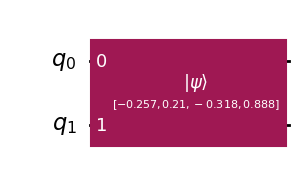

In [14]:
# Cell 13: Amplitude Encoding
"""
Amplitude Encoding: Maps data to state amplitudes
- Most efficient (log₂(N) qubits for N features)
- Requires normalization
- Complex state preparation
"""

print("\n" + "="*80)
print("AMPLITUDE ENCODING")
print("="*80)

def amplitude_encoding_demo(data_point):
    """Demonstrate amplitude encoding"""
    n_qubits = int(np.ceil(np.log2(len(data_point))))
    qc = QuantumCircuit(n_qubits)

    # Normalize data
    norm = np.linalg.norm(data_point)
    normalized = data_point / norm if norm > 0 else data_point

    # Pad to power of 2
    padded = np.pad(normalized, (0, 2**n_qubits - len(normalized)))

    qc.initialize(padded, range(n_qubits))
    return qc, normalized, padded

sample_data = X_train_reduced[0]
amp_circuit, normalized, padded = amplitude_encoding_demo(sample_data)

print(f"Original data: {sample_data}")
print(f"Normalized data: {normalized}")
print(f"Padded data (length {len(padded)}): {padded}")
print(f"Amplitude encoding circuit for {len(sample_data)} features:")
print(f"Requires {amp_circuit.num_qubits} qubits")
print(f"\nCircuit:")
print(amp_circuit)

# Visualize
amp_circuit.draw("mpl")



ANGLE ENCODING
Data to encode: [-0.48277585  0.39542978 -0.59786253  1.67160356]
Rotation angles (×π): [-0.48277585  0.39542978 -0.59786253  1.67160356]
Angle encoding circuit:
Uses 4 qubits (one per feature)

Circuit:
     ┌─────────────┐
q_0: ┤ Ry(-1.5167) ├
     └┬────────────┤
q_1: ─┤ Ry(1.2423) ├
     ┌┴────────────┤
q_2: ┤ Ry(-1.8782) ├
     └┬────────────┤
q_3: ─┤ Ry(5.2515) ├
      └────────────┘


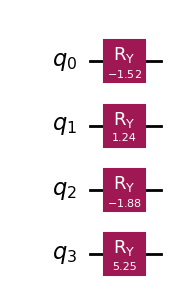

In [15]:
# Cell 14: Angle Encoding
"""
Angle Encoding: Encodes features as rotation angles
- One qubit per feature
- Simple implementation
- Easy to understand
"""

print("\n" + "="*80)
print("ANGLE ENCODING")
print("="*80)

def angle_encoding_demo(data_point):
    """Demonstrate angle encoding"""
    n_qubits = len(data_point)
    qc = QuantumCircuit(n_qubits)

    for i, value in enumerate(data_point):
        qc.ry(value * np.pi, i)  # Rotate by feature value

    return qc

angle_circuit = angle_encoding_demo(sample_data)

print(f"Data to encode: {sample_data}")
print(f"Rotation angles (×π): {sample_data}")
print(f"Angle encoding circuit:")
print(f"Uses {angle_circuit.num_qubits} qubits (one per feature)")
print(f"\nCircuit:")
print(angle_circuit)

# Visualize
angle_circuit.draw('mpl')



BASIS ENCODING
Binary data: [1, 0, 1, 1]
Resulting state: |1011⟩
Basis encoding circuit:
Uses 4 qubits

Circuit:
     ┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     ├───┤
q_3: ┤ X ├
     └───┘


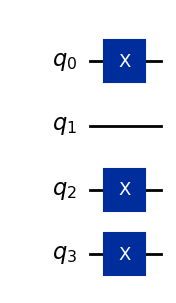

In [16]:
# Cell 15: Basis Encoding
"""
Basis Encoding: Maps classical bits to basis states
- Direct mapping: |0⟩ or |1⟩
- One qubit per bit
- Least efficient but simple
"""

print("\n" + "="*80)
print("BASIS ENCODING")
print("="*80)

def basis_encoding_demo(binary_data):
    """Demonstrate basis encoding"""
    n_qubits = len(binary_data)
    qc = QuantumCircuit(n_qubits)

    for i, bit in enumerate(binary_data):
        if bit == 1:
            qc.x(i)

    return qc

binary_sample = [1, 0, 1, 1]
basis_circuit = basis_encoding_demo(binary_sample)

print(f"Binary data: {binary_sample}")
print(f"Resulting state: |{''.join(map(str, binary_sample))}⟩")
print(f"Basis encoding circuit:")
print(f"Uses {basis_circuit.num_qubits} qubits")
print(f"\nCircuit:")
print(basis_circuit)

# Visualize
basis_circuit.draw("mpl")



FEATURE MAPS: ZZ Feature Map
ZZ Feature Map created
  - Number of qubits: 4
  - Number of parameters: 4
  - Circuit depth: 1
  - Repetitions: 2
  - Entanglement: linear

Circuit structure:
     ┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«             ┌─────────────┐                   »
«q_0: ────────┤ P(2.0*x[0]) ├───────────────────»
«             └─────────────┘              ┌

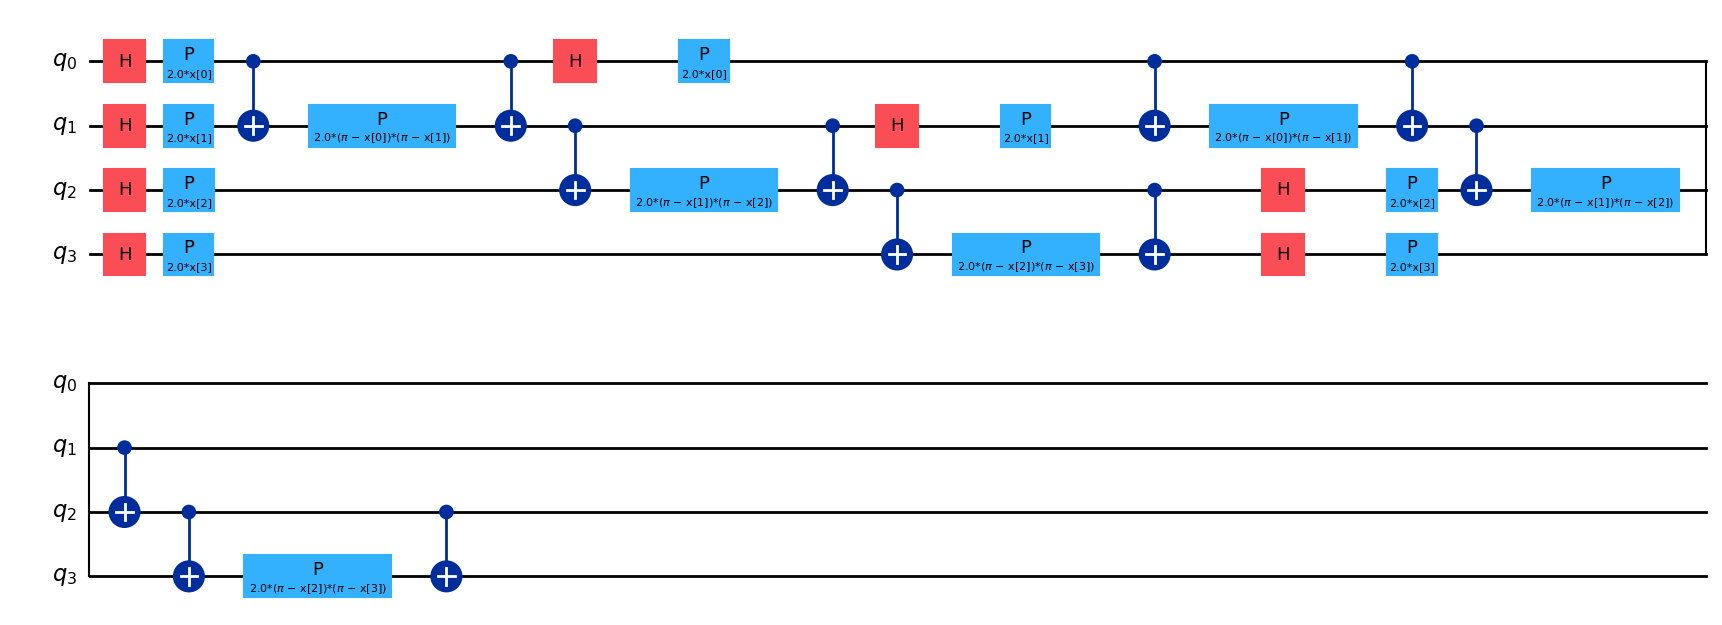

In [17]:
# Cell 16: Feature Maps - ZZ Feature Map
"""
Feature Maps: Transform data to high-dimensional quantum spaces

ZZ Feature Map:
- Creates entanglement between qubits
- Uses ZZ interactions: exp(i(π-x₁)(π-x₂)ZZ)
- Good for capturing feature correlations
"""

print("\n" + "="*80)
print("FEATURE MAPS: ZZ Feature Map")
print("="*80)

# ZZ Feature Map
zz_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')

print(f"ZZ Feature Map created")
print(f"  - Number of qubits: {zz_map.num_qubits}")
print(f"  - Number of parameters: {zz_map.num_parameters}")
print(f"  - Circuit depth: {zz_map.depth()}")
print(f"  - Repetitions: 2")
print(f"  - Entanglement: linear")

print(f"\nCircuit structure:")
print(zz_map.decompose())

# Visualize
zz_map.decompose().draw('mpl')



FEATURE MAPS: Pauli Feature Map
Pauli Feature Map created
  - Number of qubits: 4
  - Number of parameters: 4
  - Circuit depth: 1
  - Pauli strings: ['Z', 'ZZ']
  - Repetitions: 2

Circuit structure:
     ┌───┐┌─────────────┐                                               »
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■────■──»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐  │  »
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──┼──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«                                                    »
«q_0: ──────────────────────────────────■─────────■──»
«                     

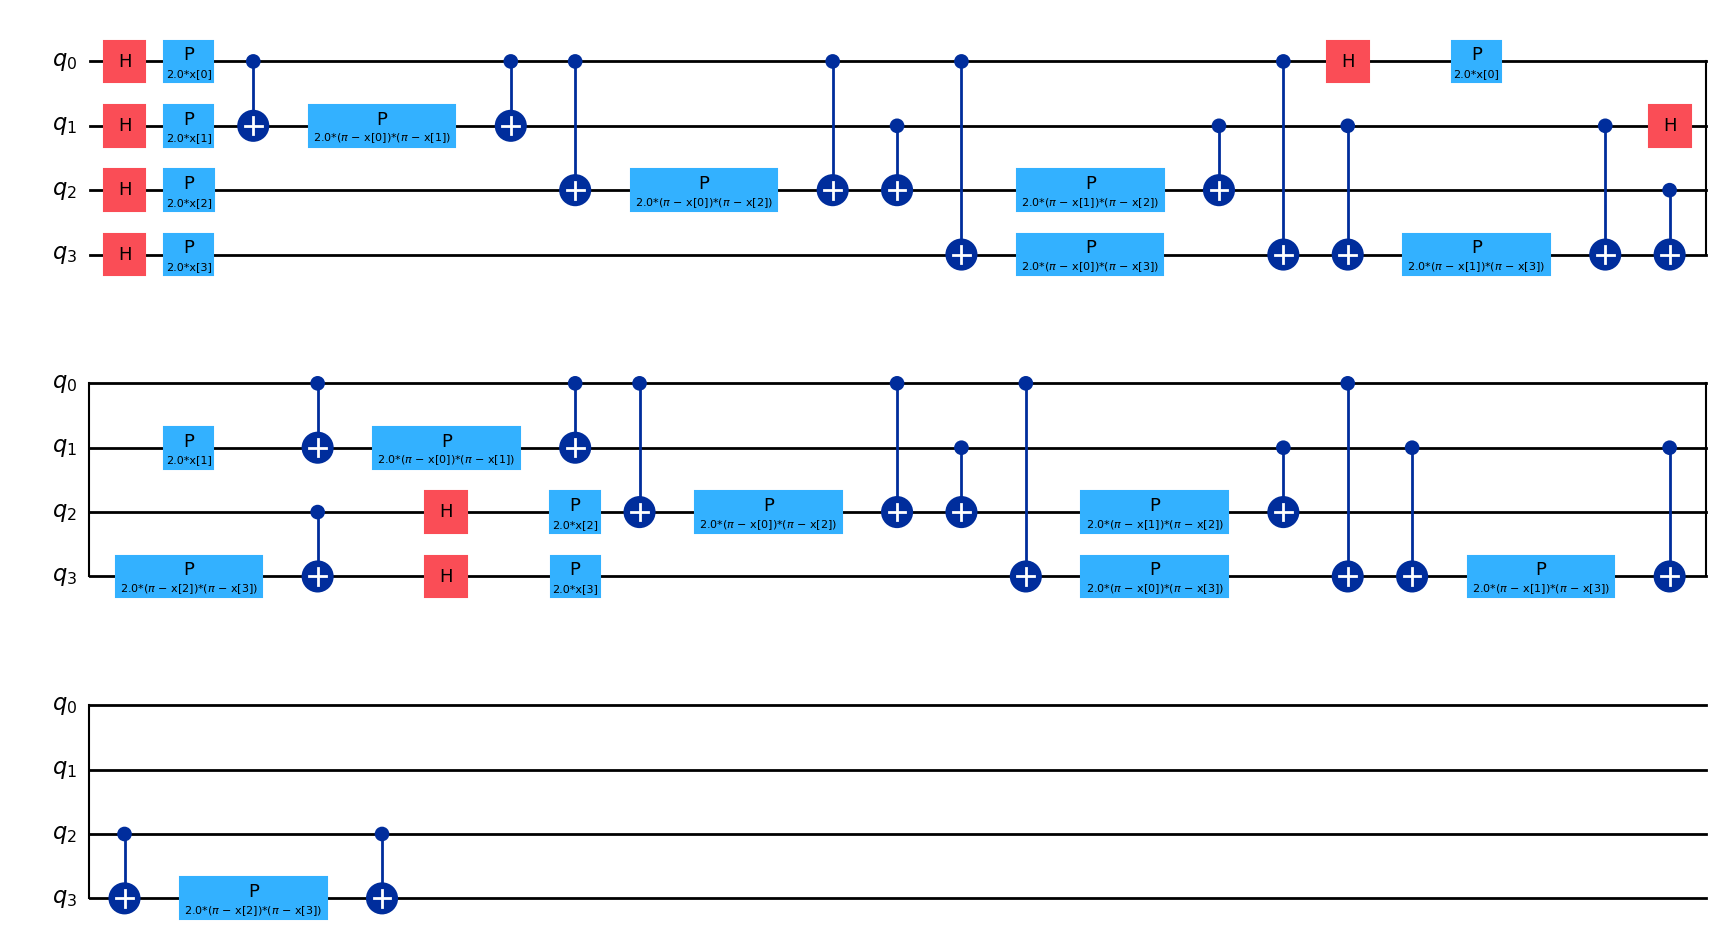

In [19]:
# Cell 17: Feature Maps - Pauli Feature Map
"""
Pauli Feature Map:
- Uses Pauli operators (X, Y, Z)
- Flexible design with different Pauli strings
- Can create complex entanglement patterns
"""

print("\n" + "="*80)
print("FEATURE MAPS: Pauli Feature Map")
print("="*80)

# Pauli Feature Map
pauli_map = PauliFeatureMap(feature_dimension=4, reps=2, paulis=['Z', 'ZZ'])

print(f"Pauli Feature Map created")
print(f"  - Number of qubits: {pauli_map.num_qubits}")
print(f"  - Number of parameters: {pauli_map.num_parameters}")
print(f"  - Circuit depth: {pauli_map.depth()}")
print(f"  - Pauli strings: ['Z', 'ZZ']")
print(f"  - Repetitions: 2")

print(f"\nCircuit structure:")
print(pauli_map.decompose())

# Visualize
pauli_map.decompose().draw('mpl')


In [20]:
# Cell 18: Variational Circuits - Introduction
"""
SECTION 4: Variational Circuits & Optimization
Slide 4: Trainable Quantum Circuits

Variational Quantum Circuits (VQC):
- Parameterized quantum circuits
- Parameters are optimized classically
- Forms the basis of many quantum ML algorithms
"""

print("\n" + "="*80)
print("SECTION 4: Variational Circuits & Optimization")
print("Slide 4: Trainable Quantum Circuits")
print("="*80)

print("""
Variational Quantum Circuits (Ansatz):

Key concepts:
1. Parameterized gates (e.g., Ry(θ), Rz(φ))
2. Trainable parameters optimized classically
3. Hybrid quantum-classical optimization loop

Structure:
- Input: Classical data
- Encoding: Feature map
- Processing: Variational circuit with parameters θ
- Measurement: Extract classical output
- Optimization: Update θ to minimize cost function
""")


SECTION 4: Variational Circuits & Optimization
Slide 4: Trainable Quantum Circuits

Variational Quantum Circuits (Ansatz):

Key concepts:
1. Parameterized gates (e.g., Ry(θ), Rz(φ))
2. Trainable parameters optimized classically
3. Hybrid quantum-classical optimization loop

Structure:
- Input: Classical data
- Encoding: Feature map
- Processing: Variational circuit with parameters θ
- Measurement: Extract classical output
- Optimization: Update θ to minimize cost function




VARIATIONAL CIRCUIT: RealAmplitudes Ansatz
Variational circuit created
  - Number of qubits: 4
  - Number of trainable parameters: 12
  - Circuit depth: 1
  - Repetitions: 2
Parameters: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7]), ParameterVectorElement(θ[8]), ParameterVectorElement(θ[9]), ParameterVectorElement(θ[10]), ParameterVectorElement(θ[11])]

Circuit structure:
     ┌──────────┐                             ┌──────────┐             »
q_0: ┤ Ry(θ[0]) ├──────────────────────■──────┤ Ry(θ[4]) ├─────────────»
     ├──────────┤                    ┌─┴─┐    ├──────────┤             »
q_1: ┤ Ry(θ[1]) ├──────────■─────────┤ X ├────┤ Ry(θ[5]) ├──────■──────»
     ├──────────┤        ┌─┴─┐    ┌──┴───┴───┐└──────────┘    ┌─┴─┐    »
q_2: ┤ Ry(θ[2]) ├──■─────┤ X ├────┤ Ry(θ[6]) ├─────■──────────┤ X

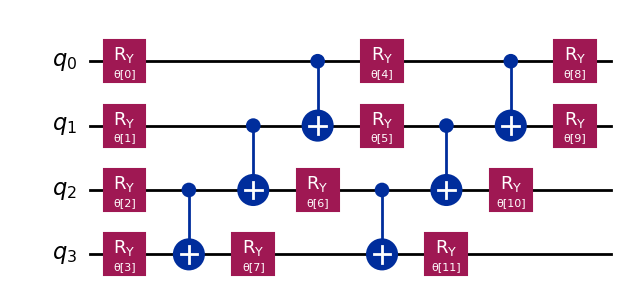

In [ ]:
# Cell 19: Variational Circuit - RealAmplitudes Ansatz
"""
RealAmplitudes Ansatz:
- Uses Ry rotations and CNOT gates
- Creates real-valued amplitudes
- Commonly used in VQC
"""

print("\n" + "="*80)
print("VARIATIONAL CIRCUIT: RealAmplitudes Ansatz")
print("="*80)

# Create a variational circuit
var_circuit = RealAmplitudes(num_qubits=4, reps=2)

print(f"Variational circuit created")
print(f"  - Number of qubits: {var_circuit.num_qubits}")
print(f"  - Number of trainable parameters: {var_circuit.num_parameters}")
print(f"  - Circuit depth: {var_circuit.depth()}")
print(f"  - Repetitions: 2")

print(f"Parameters: {list(var_circuit.parameters)}")

print(f"\nCircuit structure:")
print(var_circuit.decompose())

# Visualize
var_circuit.decompose().draw('mpl')


In [22]:
# Cell 20: Gradient Computation - Parameter Shift Rule
"""
GRADIENT-BASED TRAINING
Slide 6: Parameter Shift Rule

The parameter shift rule allows us to compute gradients on quantum hardware:
∇f(θ) = [f(θ + π/2) - f(θ - π/2)] / 2

This is crucial because:
- Quantum circuits are not differentiable in the classical sense
- We can't use backpropagation directly
- Parameter shift gives exact gradients
"""

print("\n" + "="*80)
print("GRADIENT COMPUTATION: Parameter Shift Rule")
print("="*80)

def parameter_shift_demo(theta):
    """Demonstrate parameter shift rule"""
    shift = np.pi / 2

    # Simple cost function: f(θ) = sin(θ)
    f_plus = np.sin(theta + shift)
    f_minus = np.sin(theta - shift)

    # Parameter shift gradient
    gradient = (f_plus - f_minus) / 2

    # Analytical gradient for comparison
    analytical_gradient = np.cos(theta)

    return gradient, analytical_gradient, f_plus, f_minus

# Test at different angles
test_angles = [0, np.pi/4, np.pi/2, np.pi, 3*np.pi/2]

print("Parameter Shift Rule Demonstration:")
print("Cost function: f(θ) = sin(θ)")
print("Analytical gradient: f'(θ) = cos(θ)")
print("\n" + "-"*70)
print(f"{'θ':>10} | {'f(θ+π/2)':>10} | {'f(θ-π/2)':>10} | {'∇PS':>10} | {'∇Analytical':>12} | {'Error':>10}")
print("-"*70)

for theta in test_angles:
    grad_ps, grad_analytical, f_plus, f_minus = parameter_shift_demo(theta)
    error = abs(grad_ps - grad_analytical)
    print(f"{theta:>10.4f} | {f_plus:>10.4f} | {f_minus:>10.4f} | {grad_ps:>10.4f} | {grad_analytical:>12.4f} | {error:>10.6f}")

print("-"*70)
print("Parameter shift rule gives exact gradients!")


GRADIENT COMPUTATION: Parameter Shift Rule
Parameter Shift Rule Demonstration:
Cost function: f(θ) = sin(θ)
Analytical gradient: f'(θ) = cos(θ)

----------------------------------------------------------------------
         θ |   f(θ+π/2) |   f(θ-π/2) |        ∇PS |  ∇Analytical |      Error
----------------------------------------------------------------------
    0.0000 |     1.0000 |    -1.0000 |     1.0000 |       1.0000 |   0.000000
    0.7854 |     0.7071 |    -0.7071 |     0.7071 |       0.7071 |   0.000000
    1.5708 |     0.0000 |     0.0000 |     0.0000 |       0.0000 |   0.000000
    3.1416 |    -1.0000 |     1.0000 |    -1.0000 |      -1.0000 |   0.000000
    4.7124 |    -0.0000 |     0.0000 |    -0.0000 |      -0.0000 |   0.000000
----------------------------------------------------------------------
Parameter shift rule gives exact gradients!


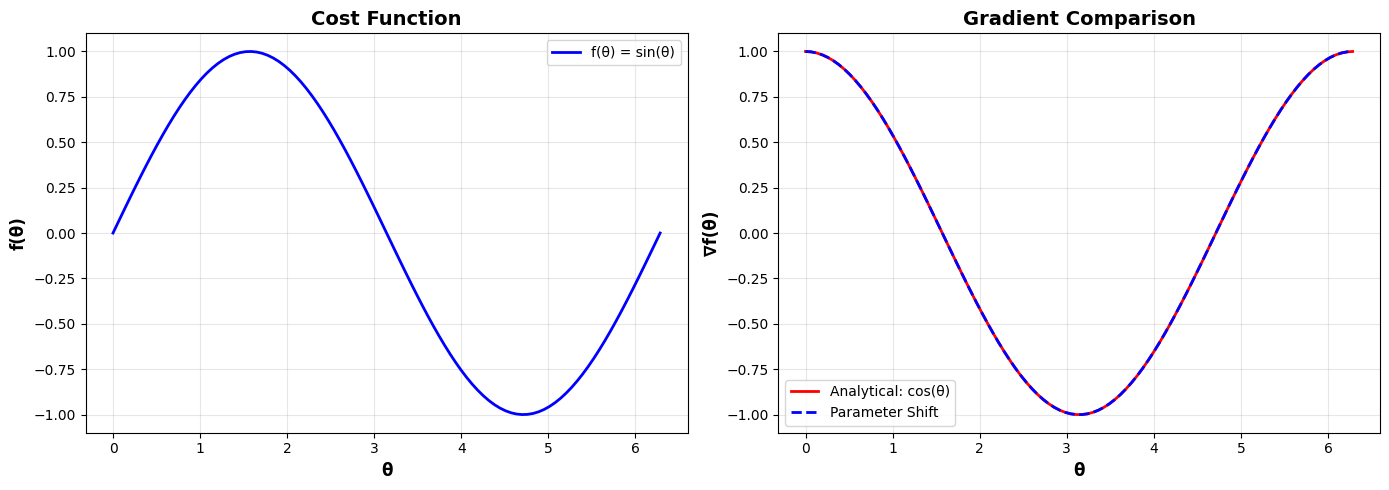

In [23]:
# Cell 21: Visualize Parameter Shift Rule
"""
Visualize how parameter shift rule works
"""

# Create visualization
theta_range = np.linspace(0, 2*np.pi, 100)
f_values = np.sin(theta_range)
gradient_analytical = np.cos(theta_range)

# Compute parameter shift gradients
gradient_ps = []
for theta in theta_range:
    # grad_ps, _ = parameter_shift_demo(theta)
    grad_ps, _, _, _ = parameter_shift_demo(theta)
    gradient_ps.append(grad_ps)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot function
axes[0].plot(theta_range, f_values, 'b-', linewidth=2, label='f(θ) = sin(θ)')
axes[0].set_xlabel('θ', fontsize=12, fontweight='bold')
axes[0].set_ylabel('f(θ)', fontsize=12, fontweight='bold')
axes[0].set_title('Cost Function', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot gradients
axes[1].plot(theta_range, gradient_analytical, 'r-', linewidth=2, label="Analytical: cos(θ)")
axes[1].plot(theta_range, gradient_ps, 'b--', linewidth=2, label="Parameter Shift")
axes[1].set_xlabel('θ', fontsize=12, fontweight='bold')
axes[1].set_ylabel('∇f(θ)', fontsize=12, fontweight='bold')
axes[1].set_title('Gradient Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

In [24]:
# Cell 22: Setup Shot Values
"""
SECTION 5: Backend Configuration
Define shot values for experiments

Shots = Number of times the circuit is executed
- More shots → Better statistics → Higher accuracy
- Fewer shots → Faster execution → Lower cost
"""

print("\n" + "="*80)
print("SECTION 5: Backend Configuration")
print("="*80)

# Different shot values to test
shot_values = [10, 100, 1000]

print(f"Testing with different shot values: {shot_values}")
print("""
Shot values explained:
- 10 shots: Fast but noisy results
- 100 shots: Balanced performance
- 1000 shots: High accuracy but slower

In real quantum computing:
- Shots affect statistical accuracy
- More shots = better approximation of true probabilities
- Trade-off between accuracy and execution time/cost
""")

# Initialize results storage
qsvc_results = []
vqc_results = []


SECTION 5: Backend Configuration
Testing with different shot values: [10, 100, 1000]

Shot values explained:
- 10 shots: Fast but noisy results
- 100 shots: Balanced performance
- 1000 shots: High accuracy but slower

In real quantum computing:
- Shots affect statistical accuracy
- More shots = better approximation of true probabilities
- Trade-off between accuracy and execution time/cost



In [26]:
# Cell 23: IDEAL SIMULATOR - Setup
"""
SECTION 6A: IDEAL SIMULATOR (AerSimulator)
Perfect quantum simulation with no noise

Characteristics:
- No gate errors
- No decoherence
- Perfect measurements
- Represents theoretical quantum advantage
"""

print("\n" + "="*80)
print("SECTION 6A: IDEAL SIMULATOR (AerSimulator)")
print("="*80)

# Create ideal simulator
ideal_backend = AerSimulator()


print("Ideal AerSimulator created")
print(f"  - Backend name: {ideal_backend.name}")
print(f"  - No noise model")
print(f"  - Perfect gate operations")
print(f"  - Ideal measurements")

print("""
This represents the best-case scenario:
- Theoretical quantum performance
- No hardware limitations
- Baseline for comparison with noisy simulations
""")


SECTION 6A: IDEAL SIMULATOR (AerSimulator)
Ideal AerSimulator created
  - Backend name: aer_simulator
  - No noise model
  - Perfect gate operations
  - Ideal measurements

This represents the best-case scenario:
- Theoretical quantum performance
- No hardware limitations
- Baseline for comparison with noisy simulations



In [27]:
# Cell 24: IDEAL SIMULATOR - QSVC Training
"""
Train Quantum Support Vector Classifier (QSVC) on Ideal Simulator
Testing with different shot values
"""
from qiskit.primitives import Sampler
print("\n" + "="*80)
print("IDEAL SIMULATOR: Training QSVC")
print("="*80)

# Feature map for QSVC
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
print(f"Feature map: {feature_map.num_qubits} qubits, depth {feature_map.depth()}")

# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training QSVC with {shots} shots on Ideal Simulator")
    print(f"{'='*70}")

    try:
        # Create sampler with ideal backend
        sampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=ideal_backend)

        # Create quantum kernel
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        # Train QSVC
        print(f"Training QSVC...")
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = qsvc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        qsvc_results.append({
            'Backend': 'Ideal Simulator',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'QSVC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        qsvc_results.append({
            'Backend': 'Ideal Simulator',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'QSVC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"IDEAL SIMULATOR - QSVC: Completed {len([r for r in qsvc_results if r['Backend']=='Ideal Simulator'])} experiments")
print(f"{'='*70}")


IDEAL SIMULATOR: Training QSVC
Feature map: 4 qubits, depth 1

Training QSVC with 10 shots on Ideal Simulator
Training QSVC...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 100 shots on Ideal Simulator
Training QSVC...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 1000 shots on Ideal Simulator
Training QSVC...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

IDEAL SIMULATOR - QSVC: Completed 3 experiments


In [29]:
# Cell 25: IDEAL SIMULATOR - VQC Training
"""
Train Variational Quantum Classifier (VQC) on Ideal Simulator
Testing with different shot values
"""
from qiskit_aer.primitives import Sampler as AerSampler
print("\n" + "="*80)
print("IDEAL SIMULATOR: Training VQC")
print("="*80)

# Create VQC components
feature_map_vqc = ZZFeatureMap(feature_dimension=4, reps=6)
ansatz = RealAmplitudes(num_qubits=4, reps=6)
optimizer = COBYLA(maxiter=100)

print(f"Feature map: {feature_map_vqc.num_qubits} qubits, depth {feature_map_vqc.depth()}")
print(f"Ansatz: {ansatz.num_parameters} parameters, depth {ansatz.depth()}")
print(f"Optimizer: COBYLA with 30 iterations")
y_train = np.array(y_train)
y_test = np.array(y_test)
# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training VQC with {shots} shots on Ideal Simulator")
    print(f"{'='*70}")

    try:
        # Create sampler with ideal backend
        sampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=ideal_backend)

        # Train VQC
        print(f"Training VQC (this may take a few minutes)...")
        vqc = VQC(
            feature_map=feature_map_vqc,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=sampler
        )

        vqc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = vqc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        vqc_results.append({
            'Backend': 'Ideal Simulator',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'VQC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        vqc_results.append({
            'Backend': 'Ideal Simulator',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'VQC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"IDEAL SIMULATOR - VQC: Completed {len([r for r in vqc_results if r['Backend']=='Ideal Simulator'])} experiments")
print(f"{'='*70}")


IDEAL SIMULATOR: Training VQC
Feature map: 4 qubits, depth 1
Ansatz: 28 parameters, depth 1
Optimizer: COBYLA with 30 iterations

Training VQC with 10 shots on Ideal Simulator
Training VQC (this may take a few minutes)...
Making predictions...
Accuracy: 0.0417 (4.17%)
Results stored

Training VQC with 100 shots on Ideal Simulator
Training VQC (this may take a few minutes)...
Making predictions...
Accuracy: 0.0833 (8.33%)
Results stored

Training VQC with 1000 shots on Ideal Simulator
Training VQC (this may take a few minutes)...
Making predictions...
Accuracy: 0.0625 (6.25%)
Results stored

IDEAL SIMULATOR - VQC: Completed 6 experiments



IDEAL SIMULATOR: RESULTS SUMMARY

QSVC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.8125 (81.25%)
Shots:    100 | Accuracy: 0.8125 (81.25%)
Shots:   1000 | Accuracy: 0.8125 (81.25%)

VQC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.0625 (6.25%)
Shots:    100 | Accuracy: 0.0000 (0.00%)
Shots:   1000 | Accuracy: 0.0000 (0.00%)
Shots:     10 | Accuracy: 0.0417 (4.17%)
Shots:    100 | Accuracy: 0.0833 (8.33%)
Shots:   1000 | Accuracy: 0.0625 (6.25%)
Saved: ideal_simulator_results.png


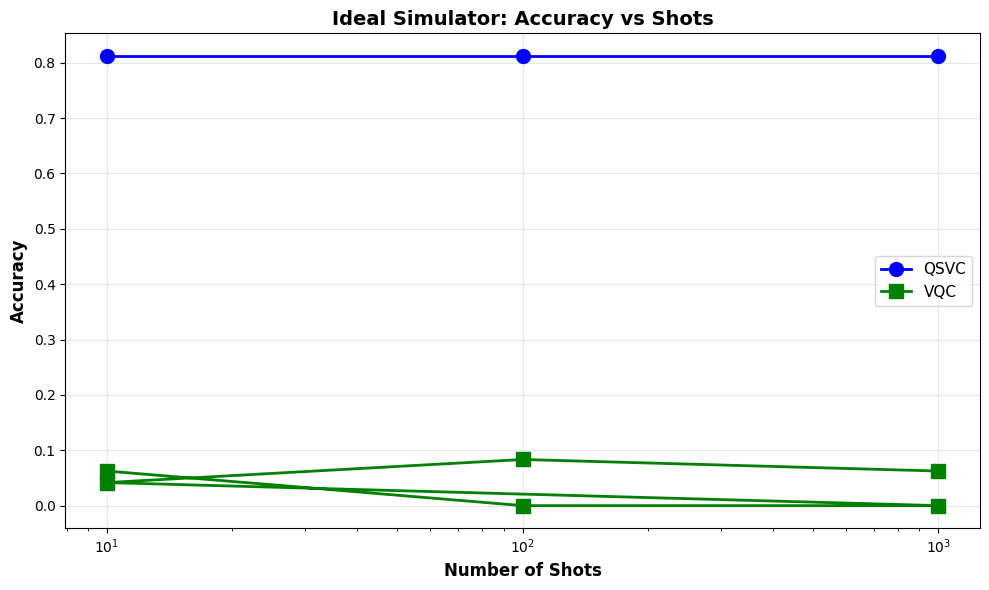

In [30]:
# Cell 26: IDEAL SIMULATOR - Results Summary
"""
Summary of Ideal Simulator results
"""

print("\n" + "="*80)
print("IDEAL SIMULATOR: RESULTS SUMMARY")
print("="*80)

ideal_qsvc = [r for r in qsvc_results if r['Backend'] == 'Ideal Simulator']
ideal_vqc = [r for r in vqc_results if r['Backend'] == 'Ideal Simulator']

print("\nQSVC Results:")
print("-" * 50)
for result in ideal_qsvc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")

print("\nVQC Results:")
print("-" * 50)
for result in ideal_vqc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

qsvc_shots = [r['Shots'] for r in ideal_qsvc]
qsvc_acc = [r['Accuracy'] for r in ideal_qsvc]
vqc_shots = [r['Shots'] for r in ideal_vqc]
vqc_acc = [r['Accuracy'] for r in ideal_vqc]

ax.plot(qsvc_shots, qsvc_acc, 'o-', linewidth=2, markersize=10, label='QSVC', color='blue')
ax.plot(vqc_shots, vqc_acc, 's-', linewidth=2, markersize=10, label='VQC', color='green')

ax.set_xlabel('Number of Shots', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Ideal Simulator: Accuracy vs Shots', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig('ideal_simulator_results.png', dpi=300, bbox_inches='tight')
print("Saved: ideal_simulator_results.png")
plt.show()

In [32]:
# Cell 27: NOISY SIMULATOR - Setup and Noise Model
"""
SECTION 6B: NOISY SIMULATOR (Custom Noise Model)
Realistic NISQ simulation with custom noise

Noise sources:
1. Depolarizing errors (gate imperfections)
2. Thermal relaxation (T1, T2 decoherence)
"""

print("\n" + "="*80)
print("SECTION 6B: NOISY SIMULATOR (Custom Noise Model)")
print("="*80)

def create_custom_noise_model():
    """Create a custom noise model with depolarizing and thermal relaxation errors"""
    noise_model = NoiseModel()

    # Depolarizing error for single-qubit gates
    error_1q = depolarizing_error(0.001, 1)  # 0.1% error rate
    noise_model.add_all_qubit_quantum_error(error_1q, ['u1', 'u2', 'u3'])

    # Depolarizing error for two-qubit gates
    error_2q = depolarizing_error(0.01, 2)  # 1% error rate
    noise_model.add_all_qubit_quantum_error(error_2q, ['cx', 'cz'])

    # Thermal relaxation (T1 and T2 times in microseconds)
    t1 = 50.0  # 50 µs
    t2 = 70.0  # 70 µs
    gate_time = 0.1  # 100 ns

    thermal_error = thermal_relaxation_error(t1, t2, gate_time)
    noise_model.add_all_qubit_quantum_error(thermal_error, ['u1', 'u2', 'u3'])

    return noise_model

# Create noise model
custom_noise_model = create_custom_noise_model()
noisy_backend = AerSimulator(noise_model=custom_noise_model)


print("\nNoise parameters:")
print("  1. Depolarizing Errors:")
print("     - Single-qubit gates: 0.1% error rate")
print("     - Two-qubit gates: 1.0% error rate")
print("\n  2. Thermal Relaxation:")
print("     - T1 (amplitude damping): 50 µs")
print("     - T2 (phase damping): 70 µs")
print("     - Gate time: 100 ns")

print("\nNoisy AerSimulator created")
print(f"  - Backend name: {noisy_backend.name}")

print("""
This simulates realistic NISQ (Noisy Intermediate-Scale Quantum) devices:
- Gate errors affect computation accuracy
- Decoherence limits circuit depth
- More realistic than ideal simulator
""")


SECTION 6B: NOISY SIMULATOR (Custom Noise Model)

Noise parameters:
  1. Depolarizing Errors:
     - Single-qubit gates: 0.1% error rate
     - Two-qubit gates: 1.0% error rate

  2. Thermal Relaxation:
     - T1 (amplitude damping): 50 µs
     - T2 (phase damping): 70 µs
     - Gate time: 100 ns

Noisy AerSimulator created
  - Backend name: aer_simulator

This simulates realistic NISQ (Noisy Intermediate-Scale Quantum) devices:
- Gate errors affect computation accuracy
- Decoherence limits circuit depth
- More realistic than ideal simulator



In [33]:
# Cell 28: NOISY SIMULATOR - QSVC Training
"""
Train Quantum Support Vector Classifier (QSVC) on Noisy Simulator
Testing with different shot values
"""

print("\n" + "="*80)
print("NOISY SIMULATOR: Training QSVC")
print("="*80)

# Feature map for QSVC (same as before)
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
print(f"Feature map: {feature_map.num_qubits} qubits, depth {feature_map.depth()}")

# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training QSVC with {shots} shots on Noisy Simulator")
    print(f"{'='*70}")

    try:
        # Create sampler with noisy backend
        sampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=noisy_backend)

        # Create quantum kernel
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        # Train QSVC
        print(f"Training QSVC with noise...")
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = qsvc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        qsvc_results.append({
            'Backend': 'Noisy Simulator',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'QSVC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        qsvc_results.append({
            'Backend': 'Noisy Simulator',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'QSVC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"NOISY SIMULATOR - QSVC: Completed {len([r for r in qsvc_results if r['Backend']=='Noisy Simulator'])} experiments")
print(f"{'='*70}")


NOISY SIMULATOR: Training QSVC
Feature map: 4 qubits, depth 1

Training QSVC with 10 shots on Noisy Simulator
Training QSVC with noise...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 100 shots on Noisy Simulator
Training QSVC with noise...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 1000 shots on Noisy Simulator
Training QSVC with noise...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

NOISY SIMULATOR - QSVC: Completed 6 experiments


In [34]:
# Cell 29: NOISY SIMULATOR - VQC Training
"""
Train Variational Quantum Classifier (VQC) on Noisy Simulator
Testing with different shot values
"""

print("\n" + "="*80)
print("NOISY SIMULATOR: Training VQC")
print("="*80)

# VQC components (same as before)
feature_map_vqc = ZZFeatureMap(feature_dimension=4, reps=1)
ansatz = RealAmplitudes(num_qubits=4, reps=2)
optimizer = COBYLA(maxiter=30)

print(f"Feature map: {feature_map_vqc.num_qubits} qubits, depth {feature_map_vqc.depth()}")
print(f"Ansatz: {ansatz.num_parameters} parameters, depth {ansatz.depth()}")
print(f"Optimizer: COBYLA with 30 iterations")

# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training VQC with {shots} shots on Noisy Simulator")
    print(f"{'='*70}")

    try:
        # Create sampler with noisy backend
        sampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=noisy_backend)

        
        # Train VQC
        print(f"Training VQC with noise (this may take a few minutes)...")
        vqc = VQC(
            feature_map=feature_map_vqc,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=sampler
        )

        vqc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = vqc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        vqc_results.append({
            'Backend': 'Noisy Simulator',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'VQC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        vqc_results.append({
            'Backend': 'Noisy Simulator',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'VQC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"NOISY SIMULATOR - VQC: Completed {len([r for r in vqc_results if r['Backend']=='Noisy Simulator'])} experiments")
print(f"{'='*70}")


NOISY SIMULATOR: Training VQC
Feature map: 4 qubits, depth 1
Ansatz: 12 parameters, depth 1
Optimizer: COBYLA with 30 iterations

Training VQC with 10 shots on Noisy Simulator
Training VQC with noise (this may take a few minutes)...
Making predictions...
Accuracy: 0.0208 (2.08%)
Results stored

Training VQC with 100 shots on Noisy Simulator
Training VQC with noise (this may take a few minutes)...
Making predictions...
Accuracy: 0.0000 (0.00%)
Results stored

Training VQC with 1000 shots on Noisy Simulator
Training VQC with noise (this may take a few minutes)...
Making predictions...
Accuracy: 0.0000 (0.00%)
Results stored

NOISY SIMULATOR - VQC: Completed 3 experiments



NOISY SIMULATOR: RESULTS SUMMARY

QSVC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.0000 (0.00%)
Shots:    100 | Accuracy: 0.0000 (0.00%)
Shots:   1000 | Accuracy: 0.0000 (0.00%)
Shots:     10 | Accuracy: 0.8125 (81.25%)
Shots:    100 | Accuracy: 0.8125 (81.25%)
Shots:   1000 | Accuracy: 0.8125 (81.25%)

VQC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.0208 (2.08%)
Shots:    100 | Accuracy: 0.0000 (0.00%)
Shots:   1000 | Accuracy: 0.0000 (0.00%)

COMPARISON: Ideal vs Noisy Simulator

QSVC - Accuracy Degradation:
----------------------------------------------------------------------
 Shots |      Ideal |      Noisy |     Degradation
----------------------------------------------------------------------
    10 |     0.8125 |     0.0000 |          81.25%
   100 |     0.8125 |     0.0000 |          81.25%
  1000 |     0.8125 |     0.0000 |          81.25%

VQC - Accuracy Degradation:
--------------------

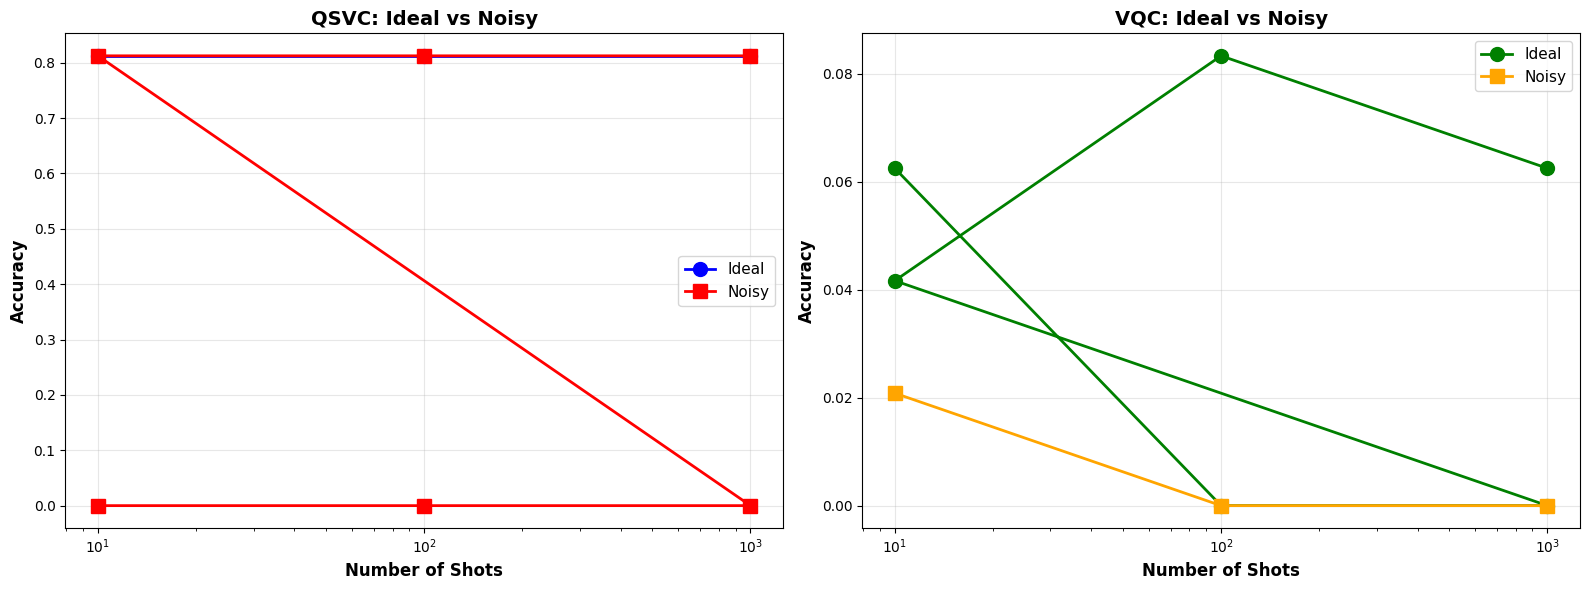

In [35]:
# Cell 30: NOISY SIMULATOR - Results Summary
"""
Summary of Noisy Simulator results and comparison with Ideal
"""

print("\n" + "="*80)
print("NOISY SIMULATOR: RESULTS SUMMARY")
print("="*80)

noisy_qsvc = [r for r in qsvc_results if r['Backend'] == 'Noisy Simulator']
noisy_vqc = [r for r in vqc_results if r['Backend'] == 'Noisy Simulator']

print("\nQSVC Results:")
print("-" * 50)
for result in noisy_qsvc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")

print("\nVQC Results:")
print("-" * 50)
for result in noisy_vqc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")

# Compare with Ideal
print("\n" + "="*80)
print("COMPARISON: Ideal vs Noisy Simulator")
print("="*80)

ideal_qsvc = [r for r in qsvc_results if r['Backend'] == 'Ideal Simulator']
ideal_vqc = [r for r in vqc_results if r['Backend'] == 'Ideal Simulator']

print("\nQSVC - Accuracy Degradation:")
print("-" * 70)
print(f"{'Shots':>6} | {'Ideal':>10} | {'Noisy':>10} | {'Degradation':>15}")
print("-" * 70)
for ideal, noisy in zip(ideal_qsvc, noisy_qsvc):
    degradation = (ideal['Accuracy'] - noisy['Accuracy']) * 100
    print(f"{ideal['Shots']:>6} | {ideal['Accuracy']:>10.4f} | {noisy['Accuracy']:>10.4f} | {degradation:>14.2f}%")

print("\nVQC - Accuracy Degradation:")
print("-" * 70)
print(f"{'Shots':>6} | {'Ideal':>10} | {'Noisy':>10} | {'Degradation':>15}")
print("-" * 70)
for ideal, noisy in zip(ideal_vqc, noisy_vqc):
    degradation = (ideal['Accuracy'] - noisy['Accuracy']) * 100
    print(f"{ideal['Shots']:>6} | {ideal['Accuracy']:>10.4f} | {noisy['Accuracy']:>10.4f} | {degradation:>14.2f}%")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# QSVC comparison
ideal_qsvc_shots = [r['Shots'] for r in ideal_qsvc]
ideal_qsvc_acc = [r['Accuracy'] for r in ideal_qsvc]
noisy_qsvc_shots = [r['Shots'] for r in noisy_qsvc]
noisy_qsvc_acc = [r['Accuracy'] for r in noisy_qsvc]

axes[0].plot(ideal_qsvc_shots, ideal_qsvc_acc, 'o-', linewidth=2, markersize=10,
             label='Ideal', color='blue')
axes[0].plot(noisy_qsvc_shots, noisy_qsvc_acc, 's-', linewidth=2, markersize=10,
             label='Noisy', color='red')
axes[0].set_xlabel('Number of Shots', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('QSVC: Ideal vs Noisy', fontsize=14, fontweight='bold')
axes[0].set_xscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# VQC comparison
ideal_vqc_shots = [r['Shots'] for r in ideal_vqc]
ideal_vqc_acc = [r['Accuracy'] for r in ideal_vqc]
noisy_vqc_shots = [r['Shots'] for r in noisy_vqc]
noisy_vqc_acc = [r['Accuracy'] for r in noisy_vqc]

axes[1].plot(ideal_vqc_shots, ideal_vqc_acc, 'o-', linewidth=2, markersize=10,
             label='Ideal', color='green')
axes[1].plot(noisy_vqc_shots, noisy_vqc_acc, 's-', linewidth=2, markersize=10,
             label='Noisy', color='orange')
axes[1].set_xlabel('Number of Shots', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('VQC: Ideal vs Noisy', fontsize=14, fontweight='bold')
axes[1].set_xscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('ideal_vs_noisy_comparison.png', dpi=300, bbox_inches='tight')
print("Saved: ideal_vs_noisy_comparison.png")
plt.show()

In [36]:
# Cell 31: FAKE BACKEND - Setup
"""
SECTION 6C: FAKE BACKEND (Real Device Characteristics)
Simulation based on actual IBM quantum hardware

Using: FakeManilaV2 (IBM 5-qubit device)
- Real calibration data
- Actual error rates from hardware
- Most realistic simulation
"""

print("\n" + "="*80)
print("SECTION 6C: FAKE BACKEND (Real Device Characteristics)")
print("="*80)

# Create fake backend
fake_backend = FakeManilaV2()

print("Fake Manila Backend created")
print(f"\nDevice Information:")
print(f"  - Device name: {fake_backend.name}")
print(f"  - Number of qubits: {fake_backend.num_qubits}")
print(f"  - Basis gates: {fake_backend.operation_names}")
print(f"  - Coupling map: {fake_backend.coupling_map}")

# Get device properties
print(f"\nDevice Properties:")
try:
    # Get some basic properties
    print(f"  - Based on real IBM quantum hardware")
    print(f"  - Includes actual calibration data")
    print(f"  - Real error rates and gate times")
    print(f"  - Realistic qubit connectivity")
except Exception as e:
    print(f"  - Properties: {e}")

print("""
FakeManilaV2 characteristics:
- 5-qubit device
- Real topology and connectivity
- Actual noise characteristics from IBM hardware
- Most realistic simulation without using real quantum computer
- Useful for testing before running on actual hardware
""")


SECTION 6C: FAKE BACKEND (Real Device Characteristics)
Fake Manila Backend created

Device Information:
  - Device name: fake_manila
  - Number of qubits: 5
  - Basis gates: ['rz', 'switch_case', 'measure', 'for_loop', 'reset', 'cx', 'delay', 'id', 'if_else', 'sx', 'x']
  - Coupling map: [[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]

Device Properties:
  - Based on real IBM quantum hardware
  - Includes actual calibration data
  - Real error rates and gate times
  - Realistic qubit connectivity

FakeManilaV2 characteristics:
- 5-qubit device
- Real topology and connectivity
- Actual noise characteristics from IBM hardware
- Most realistic simulation without using real quantum computer
- Useful for testing before running on actual hardware



In [37]:
# Cell 32: FAKE BACKEND - QSVC Training
"""
Train Quantum Support Vector Classifier (QSVC) on Fake Backend
Testing with different shot values
"""

print("\n" + "="*80)
print("FAKE BACKEND: Training QSVC")
print("="*80)

# Feature map for QSVC (same as before)
feature_map = ZZFeatureMap(feature_dimension=4, reps=2, entanglement='linear')
print(f"Feature map: {feature_map.num_qubits} qubits, depth {feature_map.depth()}")

# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training QSVC with {shots} shots on Fake Manila")
    print(f"{'='*70}")

    try:
        # Create sampler with fake backend
        

        sampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=fake_backend)

        # Create quantum kernel
        fidelity = ComputeUncompute(sampler=sampler)
        quantum_kernel = FidelityQuantumKernel(feature_map=feature_map, fidelity=fidelity)

        # Train QSVC
        print(f"Training QSVC on fake hardware...")
        qsvc = QSVC(quantum_kernel=quantum_kernel)
        qsvc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = qsvc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        qsvc_results.append({
            'Backend': 'Fake Manila',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'QSVC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        qsvc_results.append({
            'Backend': 'Fake Manila',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'QSVC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"FAKE BACKEND - QSVC: Completed {len([r for r in qsvc_results if r['Backend']=='Fake Manila'])} experiments")
print(f"{'='*70}")


FAKE BACKEND: Training QSVC
Feature map: 4 qubits, depth 1

Training QSVC with 10 shots on Fake Manila
Training QSVC on fake hardware...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 100 shots on Fake Manila
Training QSVC on fake hardware...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

Training QSVC with 1000 shots on Fake Manila
Training QSVC on fake hardware...
Making predictions...
Accuracy: 0.8125 (81.25%)
Results stored

FAKE BACKEND - QSVC: Completed 3 experiments


In [38]:
# Cell 33: FAKE BACKEND - VQC Training
"""
Train Variational Quantum Classifier (VQC) on Fake Backend
Testing with different shot values
"""

print("\n" + "="*80)
print("FAKE BACKEND: Training VQC")
print("="*80)

# VQC components (same as before)
feature_map_vqc = ZZFeatureMap(feature_dimension=4, reps=1)
ansatz = RealAmplitudes(num_qubits=4, reps=2)
optimizer = COBYLA(maxiter=30)

print(f"Feature map: {feature_map_vqc.num_qubits} qubits, depth {feature_map_vqc.depth()}")
print(f"Ansatz: {ansatz.num_parameters} parameters, depth {ansatz.depth()}")
print(f"Optimizer: COBYLA with 30 iterations")

# Test each shot value
for shots in shot_values:
    print(f"\n{'='*70}")
    print(f"Training VQC with {shots} shots on Fake Manila")
    print(f"{'='*70}")

    try:
        # Create sampler with fake backend
        ssampler = Sampler()
        sampler.options.default_shots = shots
        sampler.set_options(backend=fake_backend)

        # Train VQC
        print(f"Training VQC on fake hardware (this may take a few minutes)...")
        vqc = VQC(
            feature_map=feature_map_vqc,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=sampler
        )

        vqc.fit(X_train_reduced, y_train)

        # Predict
        print(f"Making predictions...")
        y_pred = vqc.predict(X_test_reduced)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

        # Store results
        vqc_results.append({
            'Backend': 'Fake Manila',
            'Shots': shots,
            'Accuracy': accuracy,
            'Model': 'VQC',
            'Predictions': y_pred
        })

        print(f"Results stored")

    except Exception as e:
        print(f"✗ Error: {str(e)}")
        vqc_results.append({
            'Backend': 'Fake Manila',
            'Shots': shots,
            'Accuracy': 0.0,
            'Model': 'VQC',
            'Predictions': None
        })

print(f"\n{'='*70}")
print(f"FAKE BACKEND - VQC: Completed {len([r for r in vqc_results if r['Backend']=='Fake Manila'])} experiments")
print(f"{'='*70}")


FAKE BACKEND: Training VQC
Feature map: 4 qubits, depth 1
Ansatz: 12 parameters, depth 1
Optimizer: COBYLA with 30 iterations

Training VQC with 10 shots on Fake Manila
Training VQC on fake hardware (this may take a few minutes)...
Making predictions...
Accuracy: 0.0000 (0.00%)
Results stored

Training VQC with 100 shots on Fake Manila
Training VQC on fake hardware (this may take a few minutes)...
Making predictions...
Accuracy: 0.0417 (4.17%)
Results stored

Training VQC with 1000 shots on Fake Manila
Training VQC on fake hardware (this may take a few minutes)...
Making predictions...
Accuracy: 0.0833 (8.33%)
Results stored

FAKE BACKEND - VQC: Completed 3 experiments


In [39]:
# Cell 34: FAKE BACKEND - Results Summary
"""
Summary of Fake Backend results and comparison with Ideal and Noisy
"""

print("\n" + "="*80)
print("FAKE BACKEND: RESULTS SUMMARY")
print("="*80)

fake_qsvc = [r for r in qsvc_results if r['Backend'] == 'Fake Manila']
fake_vqc = [r for r in vqc_results if r['Backend'] == 'Fake Manila']

print("\nQSVC Results:")
print("-" * 50)
for result in fake_qsvc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")

print("\nVQC Results:")
print("-" * 50)
for result in fake_vqc:
    print(f"Shots: {result['Shots']:>6} | Accuracy: {result['Accuracy']:.4f} ({result['Accuracy']*100:.2f}%)")


FAKE BACKEND: RESULTS SUMMARY

QSVC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.8125 (81.25%)
Shots:    100 | Accuracy: 0.8125 (81.25%)
Shots:   1000 | Accuracy: 0.8125 (81.25%)

VQC Results:
--------------------------------------------------
Shots:     10 | Accuracy: 0.0000 (0.00%)
Shots:    100 | Accuracy: 0.0417 (4.17%)
Shots:   1000 | Accuracy: 0.0833 (8.33%)
